In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Read the CSV file
data = pd.read_csv("train.csv")

# Iterate over each row in the DataFrame
for index, row in data.iterrows():
    image_name = row['image_name'] + '.jpg'  # Add '.jpg' extension
    diagnosis = row['diagnosis']
    
    # Skip files without a diagnosis
    if pd.isna(diagnosis):
        print(f"Skipping file without a diagnosis: {image_name}")
        continue
    
    # Construct the old and new file paths
    old_path = os.path.join("C:/Developer/Cancer/train", image_name).replace("\\", "/")
    new_path = os.path.join("C:/Developer/Cancer/train", f"{diagnosis}_{image_name}").replace("\\", "/")
    
   
    
    # Check if the old file exists
    if os.path.exists(old_path):
        # Rename the file
        os.rename(old_path, new_path)

print("All files in the train directory renamed successfully.")


All files in the train directory renamed successfully.


In [2]:
from PIL import Image
import os
import pandas as pd

# Read the CSV file
data = pd.read_csv("train.csv")

# Initialize empty lists to store images and labels
images = []
labels = []

# Iterate over each row in the DataFrame
for index, row in data.iterrows():
    image_name = row['image_name'] + '.jpg'  # Add '.jpg' extension
    diagnosis = row['diagnosis']
    
    # Skip files without a named label or with label 'unknown'
    if pd.isna(diagnosis) or diagnosis == 'unknown':
        continue
    
    # Construct the file path
    file_path = os.path.join("C:/Developer/Cancer/train", diagnosis, image_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the image
        image = Image.open(file_path)
        
        # Append the image and label to the lists
        images.append(image)
        labels.append(diagnosis)
    else:
        print(f"File not found: {file_path}")



In [3]:
print(len(images))
print(len(labels))

6002
6002


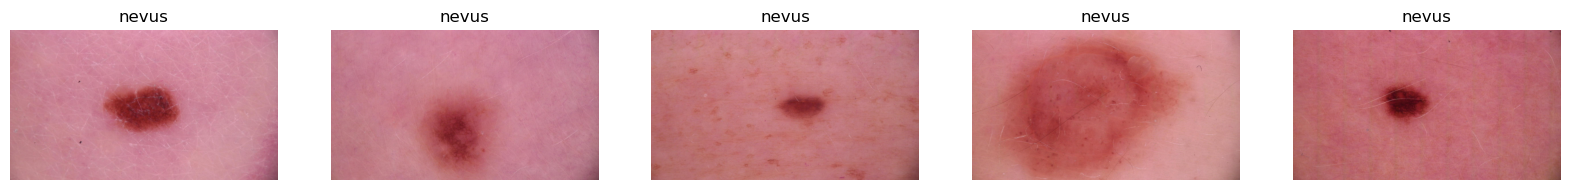

In [4]:
#print few images from image with their label 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title(labels[i])
    axes[i].axis('off')

plt.show()

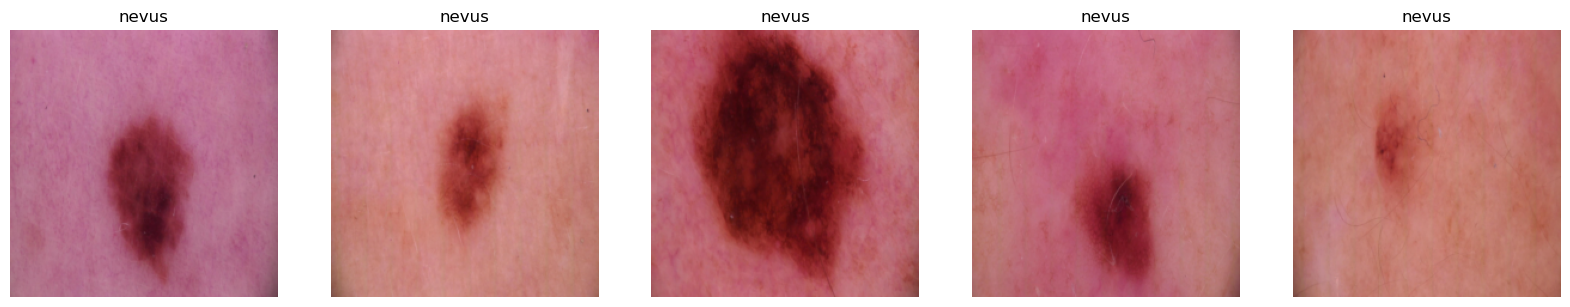

In [5]:
# Convert the images to RGB if not rgb already
images = [image.convert('RGB') if image.mode != 'RGB' else image for image in images]
#simple image augmentation
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch

# Use LabelEncoder to encode labels into numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = ImageDataset(images, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

# Load a batch of images and labels
images, labels = next(iter(dataloader))

# Display the images and labels

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    image = images[i].permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title(labels[i])
    axes[i].axis('off')

plt.show()


In [7]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
num_classes = len(set(labels))  # Number of unique classes
model = CNNModel(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0], data[1]

        optimizer.zero_grad()

        outputs = model(inputs)

        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

# Save the model if needed
# torch.save(model.state_dict(), 'model.pth')

ValueError: too many dimensions 'str'